# Multi channels feature extraction using KRONOS Embedding
The workflow involves extracting patch embeddings from multiplex images

## Prerequisites

Ensure you have the following data prepared:

1. **Multiplex Images (multi-marker TIFFs)**
e.g.
```
split_channels/
├── E-19-1584_[4724,57210]_component_data.tif
├── E-19-1584_[4724,58210]_component_data.tif
├── E-20-1584_[6064,57210]_component_data.tif
```
2. **Marker Metadata**: A CSV file containing the following columns:
    - `channel_id`: Identifier for the image channel.
    - `marker_name`: Name of the marker (e.g., DAPI, CD20).
    - `marker_id`: Unique ID for the marker.
    - `marker_mean`: Mean intensity value for normalization.
    - `marker_std`: Standard deviation for normalization.
 

## Import Required Packages

We begin by importing the necessary libraries and modules for the workflow.

In [1]:
import os
import random
from pathlib import Path

import h5py
import torch
import tifffile

# Disable external decoding libraries such as imagecodecs
tifffile.imagecodecs = None
tifffile._imagecodecs = None
from tifffile import TiffFile
from torch.utils.data import DataLoader, IterableDataset
from tqdm import tqdm
from stamp.preprocessing.extractor.kronos import create_model_from_pretrained

/mnt/bulk-neptune/laura/multiplex/STAMP/src/stamp/preprocessing/extractor/kronos.py:283: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/mnt/bulk-neptune/laura/multiplex/STAMP/src/stamp/preprocessing/extractor/kronos.py:403: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/mnt/bulk-neptune/laura/multiplex/STAMP/src/stamp/preprocessing/extractor/kronos.py:912: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")


## Configuration

In [2]:
# Configuration dictionary containing all parameters for the pipeline
config = {
    "multiplex_image_path": "/mnt/bulk-neptune/laura/multiplex/data/IMPALUX_CA/MSIs_unmixed",
    "h5_path": "/mnt/bulk-sirius/nguyenmin/multiplex/features/MSIs_unmixed_32px",  # Path to save the H5 files
    # Model-related parameters
    "checkpoint_path": "hf_hub:MahmoodLab/kronos",  # Path to the pre-trained model checkpoint (local or Hugging Face Hub)
    "hf_auth_token": None,  # Authentication token for Hugging Face Hub (if checkpoint is from the Hub)
    # Marker metadata
    "marker_order": [  # List of markers in the order they appear in the multiplex images
        "DAPI",
        "panCK",
        "DLL3",
        "cMET",
        "Prame",
        "HER2",
        "Trop2",
    ],
    "marker_means": [  # Mean values for each marker channel (for normalization)
        0.083207167266239,
        3.858771,
        0.845861,
        0.916094,
        0.520865,
        0.002635053845242,
        0.968378,
    ],
    "marker_stds": [  # Standard deviation values for each marker channel (for normalization)
        0.095881901595564,
        5.253960,
        1.679520,
        2.228641,
        1.072089,
        0.002679981377219,
        1.748987,
    ],
    # Image processing parameters
    "patch_size": 32,  # Size of the patches to be extracted from the multiplex image
    "batch_size": 1,  # Batch size for processing patches through the model
}

## Data class

In [3]:
class PatchIterable(IterableDataset):
    """
    IterableDataset for *multichannel* multiplex TIFFs.
    Supports TIFFs shaped (C, H, W), extracting (C, patch_size, patch_size) patches.
    Normalizes each channel using config["marker_means"] and config["marker_stds"].
    """

    def __init__(self, config: dict, shuffle: bool = False):
        self.folder_path = Path(config["multiplex_image_path"])
        self.h5_path = Path(config["h5_path"])

        self.marker_order = config["marker_order"]  # ["DAPI","panCK",...]
        self.patch_size = config["patch_size"]

        # Convert marker means/stds to tensors of shape (C,1,1)
        self.mean = torch.tensor(config["marker_means"], dtype=torch.float32)[
            :, None, None
        ]
        self.std = torch.tensor(config["marker_stds"], dtype=torch.float32)[
            :, None, None
        ]

        self.shuffle = shuffle

        # -------------------------------
        # 1) list all .tif files
        # -------------------------------
        all_tifs = sorted(
            [f for f in self.folder_path.iterdir() if f.suffix.lower() == ".tif"]
        )

        # -------------------------------
        # 2) keep only missing .h5 files
        # -------------------------------
        self.file_paths = []
        for tif in all_tifs:
            stem = tif.stem  # "sample_001_panCK"
            expected_h5 = self.h5_path / f"{stem}.h5"

            if not expected_h5.exists():
                self.file_paths.append(tif)

    def __iter__(self):
        paths = self.file_paths.copy()
        if self.shuffle:
            random.shuffle(paths)

        for path in paths:
            fname = os.path.basename(path).replace(".tif", "")

            # Load multichannel TIFF → shape: (C, H, W)
            with TiffFile(path) as tif:
                img = tif.series[0].asarray()

            if img.ndim != 3:
                raise ValueError(
                    f"Expected TIFF shape (C,H,W) but got {img.shape} in file {path}"
                )

            C, H, W = img.shape
            ps = self.patch_size

            # Extract patches over height & width
            for y in range(0, H - ps + 1, ps):
                for x in range(0, W - ps + 1, ps):
                    patch = img[:, y : y + ps, x : x + ps]  # (C, ps, ps)
                    patch = torch.tensor(patch, dtype=torch.float32)

                    # Channel-wise normalization
                    patch = (patch - self.mean) / self.std  # (C, ps, ps)

                    yield patch, x, y, fname

## Init dataset

In [4]:
os.makedirs(config["h5_path"], exist_ok=True)

dataset = PatchIterable(config)
dataloader = DataLoader(
    dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0
)

## Visualize Clustering Results along with Multiplex Image

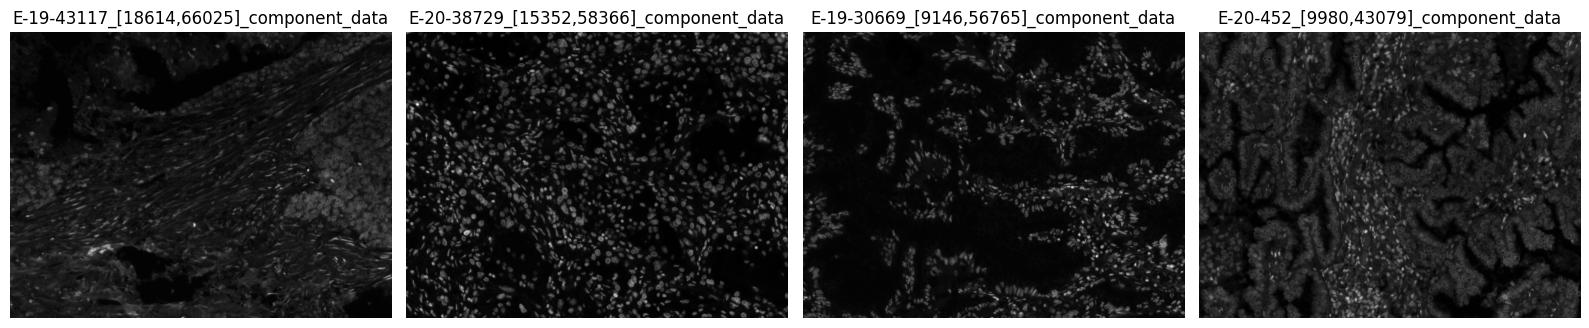

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

n = 4  # number of TIFFs to show
paths = random.sample(dataset.file_paths, n)

cols = 4
rows = int(np.ceil(n / cols))

plt.figure(figsize=(4 * cols, 4 * rows))
for i, p in enumerate(paths):
    img = np.array(Image.open(p))

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(p.stem)
    plt.axis("off")

plt.tight_layout()
plt.show()


## Load KRONOS Model

In [ ]:
model, precision, embedding_dim = create_model_from_pretrained(
    checkpoint_path="hf_hub:MahmoodLab/kronos",  # or provide a local path
    cfg_path=None,  # or provide a local path
    hf_auth_token="",  # Authentication token for Hugging Face Hub
    cache_dir="./model_assets",
    cfg={
        "model_type": "vits16",
        "token_overlap": False,
    },  # or provide None if using cfg_path
)

print("Model precision: ", precision)
print("Model embedding dimension: ", embedding_dim)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

<@beartype(stamp.preprocessing.extractor.kronos.Block.__init__) at 0x7f677282eca0>:67: UserWarning: Method stamp.preprocessing.extractor.kronos.Block.__init__() parameter mlp_ratio=4 violates type hint <class 'float'>, as int 4 not instance of float.
/mnt/bulk-neptune/laura/multiplex/STAMP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded model weights from ./model_assets/models--MahmoodLab--kronos/snapshots/8edc2719ad67b2e2b766073b35c6cf8e6f5da516/kronos_vits16_model.pt
Model precision:  torch.float32
Model embedding dimension:  384
Using device: cuda


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): BlockChunk(
      (0-2): 3 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): LayerScale()
  

## Feature Extraction

In [7]:
import time
from pathlib import Path

out_dir = Path(config["h5_path"])
total = len(dataset.file_paths)
start_time = time.time()
last_print = -1

h5_files = {}

file_paths = sorted(
    os.path.join(config["multiplex_image_path"], f)
    for f in os.listdir(config["multiplex_image_path"])
    if f.endswith(".tif")
)

file_count = 0
last_file_id = None

for batch, coord_x, coord_y, fname in dataloader:  # total=len(file_paths)
    # Squeeze batch elements
    fname = fname[0]
    coord_x = coord_x.item()
    coord_y = coord_y.item()

    # derive stable TIFF identifier
    file_id = fname.split("[")[0].rstrip("_")

    if fname not in h5_files:
        num_markers = len(config["marker_order"])
        tokens_per_side = config["patch_size"] // 16

        assert config["patch_size"] % 16 == 0, "Patch size must be divisible by 16"

        hf = h5py.File(os.path.join(config["h5_path"], f"{fname}.h5"), "w")

        h5_files[fname] = {
            "file": hf,

            "patch_ds": hf.create_dataset(
                "patch_embeddings",
                shape=(0, 384),
                maxshape=(None, 384),
                dtype="f",
            ),

            "marker_ds": hf.create_dataset(
                "marker_embeddings",
                shape=(0, num_markers, 384),
                maxshape=(None, num_markers, 384),
                dtype="f",
            ),

            "token_ds": hf.create_dataset(
                "token_embeddings",
                shape=(0, num_markers, tokens_per_side, tokens_per_side, 384),
                maxshape=(None, num_markers, tokens_per_side, tokens_per_side, 384),
                dtype="f",
            ),

            "coord_x_ds": hf.create_dataset(
                "coord_x", shape=(0,), maxshape=(None,), dtype="i"
            ),

            "coord_y_ds": hf.create_dataset(
                "coord_y", shape=(0,), maxshape=(None,), dtype="i"
            ),
        }


        file_count += 1
        elapsed = time.time() - start_time
        print(
            f"\rProcessed {file_count}/{total} TIFF files "
            f"| {elapsed/60:.1f} min elapsed",
            end="",
            flush=True,
        )

    hf_entry = h5_files[fname]

    # Run model
    with torch.no_grad():
        patch_embeddings, marker_embeddings, token_embeddings = model(batch.to(device))

    if not torch.isfinite(patch_embeddings).all():
        print("NaN detected — skipping patch", fname, coord_x, coord_y)
        continue

    # Convert to numpy
    patch_np = patch_embeddings.cpu().numpy()
    marker_np = marker_embeddings.cpu().numpy()
    token_np = token_embeddings.cpu().numpy()

    # Get current size and resize
    start = hf_entry["patch_ds"].shape[0]
    end = start + patch_np.shape[0]

    hf_entry["patch_ds"].resize(end, axis=0)
    hf_entry["marker_ds"].resize(end, axis=0)
    hf_entry["token_ds"].resize(end, axis=0)
    hf_entry["coord_x_ds"].resize(end, axis=0)
    hf_entry["coord_y_ds"].resize(end, axis=0)

    # Save
    hf_entry["patch_ds"][start:end] = patch_np
    hf_entry["marker_ds"][start:end] = marker_np
    hf_entry["token_ds"][start:end] = token_np
    hf_entry["coord_x_ds"][start:end] = [coord_x]
    hf_entry["coord_y_ds"][start:end] = [coord_y]


# Don't forget to close files
for entry in h5_files.values():
    entry["file"].close()

Processed 7709/7709 TIFF files | 1791.2 min elapsed